# **Shopper Spectrum:** 

# **Libraries Used**

In [435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import datetime as dt
import pickle

# **About Dataset**

Load Dataset:

In [436]:
df = pd.read_csv('dataset\online_retail.csv')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2023-12-09 12:50:00,4.15,12680.0,France


* There are 540k+ data and 8 columns

Dataset info:

In [437]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


* Date-time conversion needed on Invoice date
* Invoice no & Stock code not needed  
* Missing values found

Dataset describe:

In [438]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


* Unusual min values on quantity and unit price.  

# **Dataset Clean**

In [439]:
df_clean = df.copy()

Remove cancelled invoices:

In [440]:
df_clean[df_clean['InvoiceNo'].str.startswith('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2022-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2022-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2022-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2022-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2022-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2023-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2023-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2023-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2023-12-09 11:58:00,1.25,17315.0,United Kingdom


In [441]:
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

Fixing quantity and unit price:

In [442]:
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

Date conversion:

In [443]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

Drop nulls:

In [444]:
df_clean.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

In [445]:
df_clean.dropna(inplace=True)

Drop unwanted columns:

In [446]:
# df_clean = df_clean.drop(columns=['InvoiceNo','StockCode','CustomerID'])

In [447]:
df_clean

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2023-12-09 12:50:00,4.15,12680.0,France


Remove duplicates:

In [448]:
df_clean.duplicated().sum()

np.int64(5192)

In [449]:
# df_clean.drop_duplicates(inplace=True)

Total price column:

In [450]:
df_clean['TotalPrice'] = round(df_clean['Quantity'] * df_clean['UnitPrice'],2)

Reset index:

In [451]:
df_clean.reset_index(drop=True, inplace=True)

Dataset cleaned:

In [452]:
df_clean

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
397879,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.0,France,10.20
397880,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.0,France,12.60
397881,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.0,France,16.60
397882,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2023-12-09 12:50:00,4.15,12680.0,France,16.60


In [453]:
df_clean.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

Outlier detection:

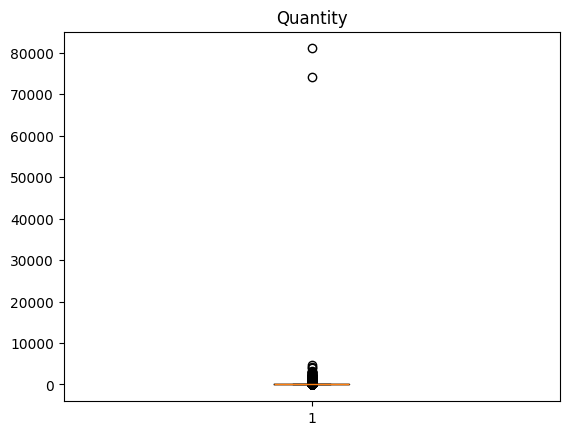

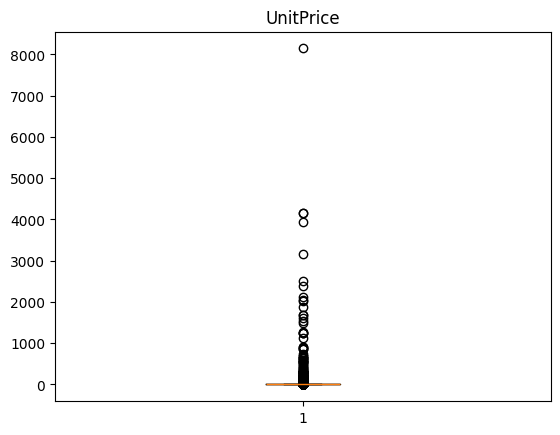

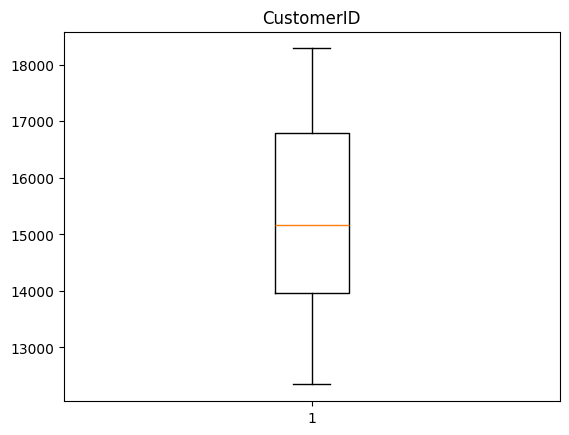

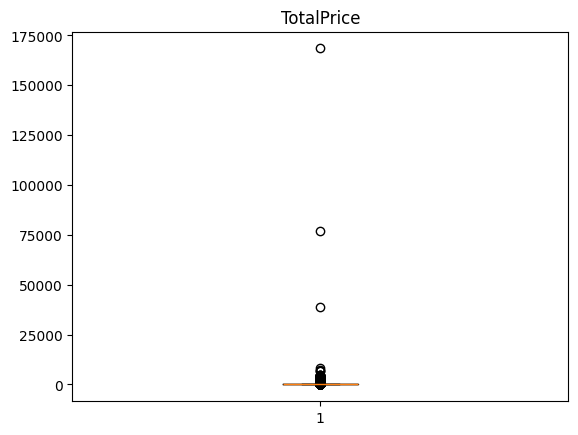

In [454]:
for i in df_clean.select_dtypes('number').columns:
    plt.boxplot(df_clean[i])
    plt.title(i)
    plt.show()
    print()

In [455]:
df_clean = df_clean[(df_clean['Quantity'] < 2000) & (df_clean['UnitPrice'] < 750) &(df_clean['TotalPrice'] < 6000)]

# **EDA**

1. Transaction volume by country:

In [456]:
country_transactions = df_clean.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)
country_transactions

Country
United Kingdom          16628
Germany                   457
France                    386
EIRE                      258
Belgium                    98
Netherlands                93
Spain                      90
Australia                  57
Portugal                   55
Switzerland                51
Finland                    41
Italy                      38
Sweden                     36
Norway                     36
Channel Islands            26
Poland                     19
Japan                      18
Denmark                    18
Austria                    17
Cyprus                     16
Unspecified                 8
Iceland                     7
Canada                      6
Malta                       5
Singapore                   5
Greece                      5
Israel                      5
USA                         5
Lithuania                   4
European Community          4
United Arab Emirates        3
Czech Republic              2
Bahrain                     2
Br

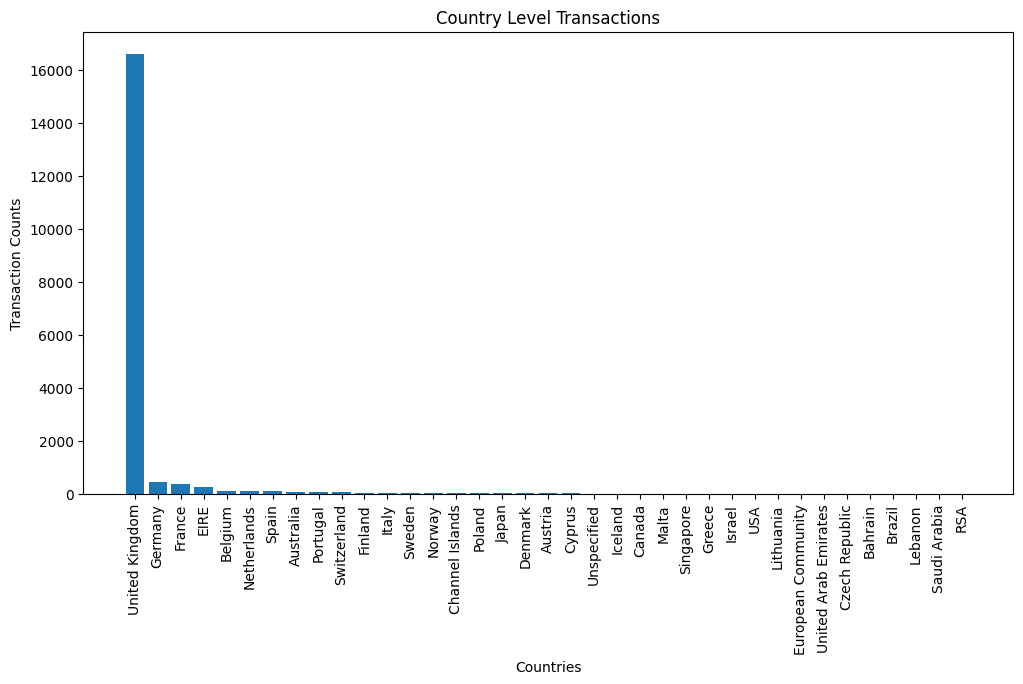

In [457]:
plt.figure(figsize=(12,6))
plt.bar(country_transactions.index,country_transactions.values)
plt.title('Country Level Transactions')
plt.xlabel('Countries')
plt.ylabel('Transaction Counts')
plt.xticks(rotation=90)
plt.show()

* UK has the highest transactions
* UK data makes the dataset highly imbalanced on other Countries.
* RSA, Saudi, Lebanon, Brazil has the lowest transaction.

2. Top-selling products:

In [458]:
top_seller = df_clean.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)
top_seller

StockCode
85099B    46181
22197     44883
84077     44143
85123A    36782
21212     33693
84879     32482
22492     26076
22616     25345
17003     22963
23084     22762
Name: Quantity, dtype: int64

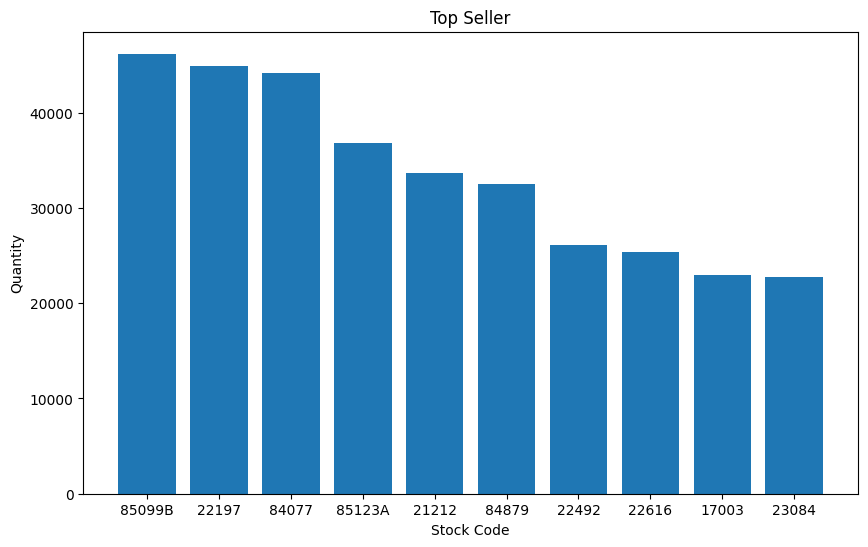

In [459]:
plt.figure(figsize=(10,6))
plt.bar(top_seller.index,top_seller.values)
plt.title('Top Seller')
plt.xlabel('Stock Code')
plt.ylabel('Quantity')
plt.show()

3. Purchase trends over time:

In [460]:
daily = df_clean.set_index('InvoiceDate').resample('D')['InvoiceNo'].nunique()

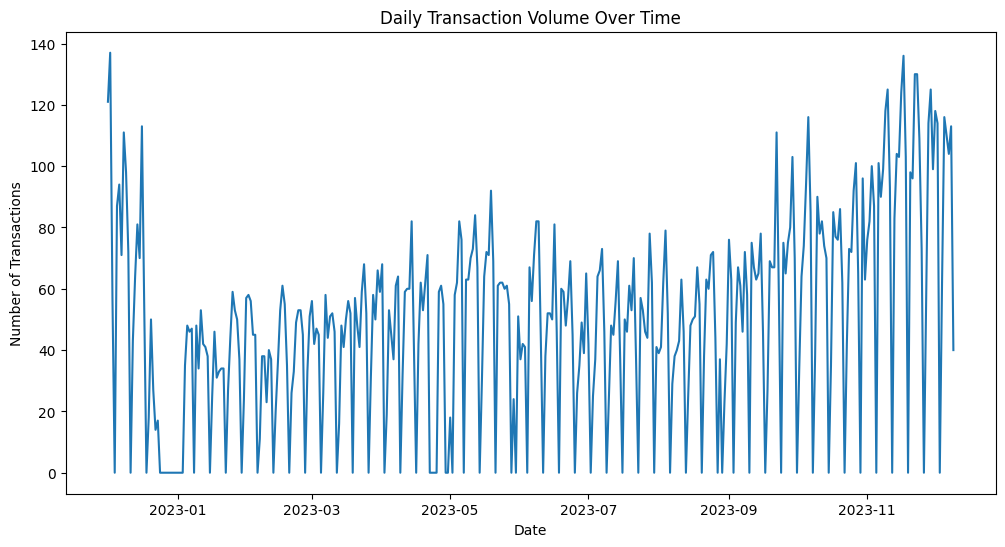

In [461]:
plt.figure(figsize=(12,6))
plt.plot(daily.index, daily.values)
plt.title("Daily Transaction Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.show()

In [462]:
monthly = df_clean.set_index('InvoiceDate').resample('MS')['InvoiceNo'].nunique()

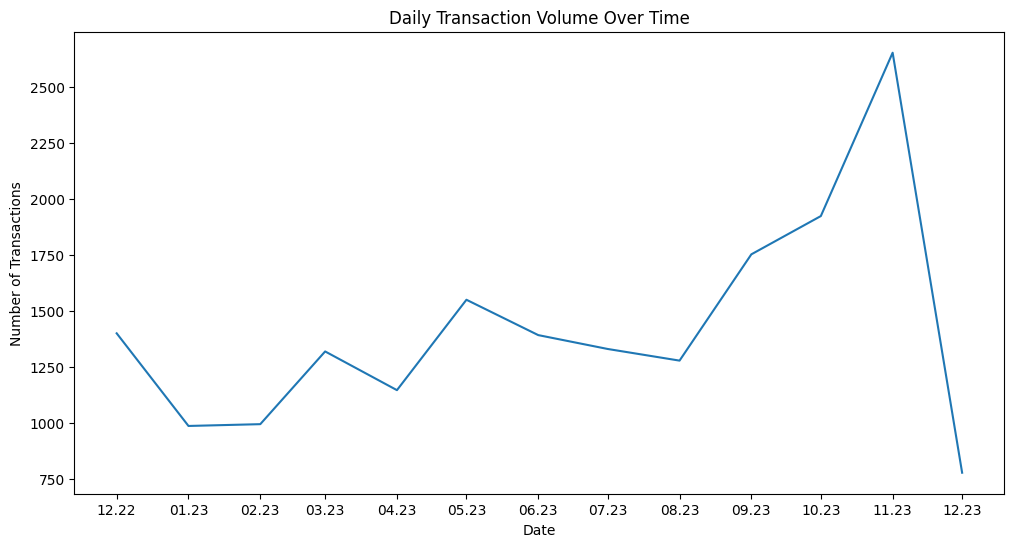

In [463]:
plt.figure(figsize=(12,6))
plt.plot(monthly.index, monthly.values)
plt.title("Daily Transaction Volume Over Time")
plt.xlabel("Date")
plt.xticks(ticks=monthly.index,labels=monthly.index.strftime('%m.%y'))
plt.ylabel("Number of Transactions")
plt.show()

* The transactions are not stable it has equal rise as well as its fall.

4. Heatmap:

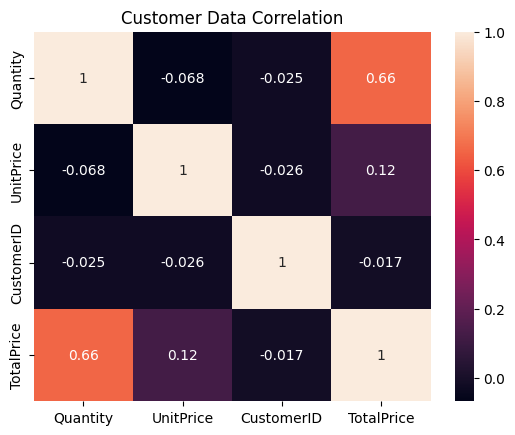

In [464]:
sns.heatmap(df_clean.corr(numeric_only=True),annot=True)
plt.title('Customer Data Correlation')
plt.show()

* Only positive correlation is total price & quantity.

# **Customer Segmentation:** 

Customer groups:

In [465]:
customer_behavior = df_clean.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

Customer average:

In [466]:
customer_behavior['Avg_Quantity'] = round(customer_behavior['Quantity'] / customer_behavior['Frequency'])
customer_behavior['Avg_Spend'] = round(customer_behavior['Monetary'] / customer_behavior['Frequency'])

In [467]:
customer_behavior.drop(columns=['Quantity'],inplace=True)

Customer based dataset:

In [468]:
customer_behavior

,Frequency,Monetary,Avg_Quantity,Avg_Spend
CustomerID,,,,
12347.0,7,4310.00,351.0,616.0
12348.0,4,1797.24,585.0,449.0
12349.0,1,1757.55,631.0,1758.0
12350.0,1,334.40,197.0,334.0
12352.0,8,2506.04,67.0,313.0
...,...,...,...,...
18280.0,1,180.60,45.0,181.0
18281.0,1,80.82,54.0,81.0
18282.0,2,178.05,52.0,89.0


Data scaling:

In [469]:
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_behavior)

Elbow method:

In [470]:
inertia = []
clusters = range(2, 11)

for k in clusters:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(customer_scaled)
    inertia.append(km.inertia_)

Elbow Plot:

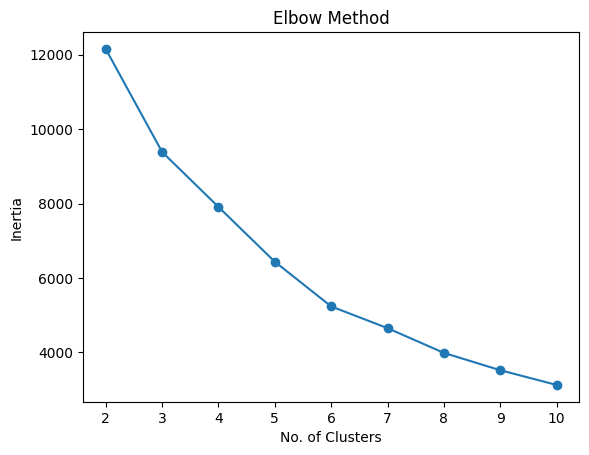

In [471]:
plt.figure()
plt.plot(clusters, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("No. of Clusters")
plt.ylabel("Inertia")
plt.show()

* 6 shows the best balance.

KMeans model:

In [472]:
final_kmeans = KMeans(n_clusters=6, random_state=42)
customer_behavior['Cluster'] = final_kmeans.fit_predict(customer_scaled)

Cluster details:

In [473]:
cluster_summary = customer_behavior.groupby('Cluster').mean().round()
print(cluster_summary)

         Frequency  Monetary  Avg_Quantity  Avg_Spend
Cluster                                              
0              3.0     862.0         159.0      275.0
1             51.0  192914.0        2000.0     4061.0
2              7.0   21357.0        2163.0     3603.0
3            120.0   53203.0         276.0      481.0
4              3.0    3002.0         611.0      936.0
5             20.0    8844.0         244.0      421.0


Cluster distributions:

In [474]:
cluster_summary['Count'] = customer_behavior['Cluster'].value_counts()
print(cluster_summary['Count'])

Cluster
0    3612
1       5
2      26
3       8
4     443
5     240
Name: Count, dtype: int64


Cluster labeling:

In [475]:
cluster_labels = {
    0: "Occasional, Low-Spend",
    1: "Regular, High-Spend",
    2: "Infrequent, High-Spend",
    3: "Frequent, Moderate-Spend",
    4: "Occasional, Moderate-Spend",
    5: "Regular, Low-Spend"
}

In [476]:
customer_behavior['Cluster'] = customer_behavior['Cluster'].map(cluster_labels)
customer_behavior[['Frequency', 'Monetary', 'Cluster']]

,Frequency,Monetary,Cluster
CustomerID,,,
12347.0,7,4310.00,"Occasional, Low-Spend"
12348.0,4,1797.24,"Occasional, Moderate-Spend"
12349.0,1,1757.55,"Occasional, Moderate-Spend"
12350.0,1,334.40,"Occasional, Low-Spend"
12352.0,8,2506.04,"Occasional, Low-Spend"
...,...,...,...
18280.0,1,180.60,"Occasional, Low-Spend"
18281.0,1,80.82,"Occasional, Low-Spend"
18282.0,2,178.05,"Occasional, Low-Spend"


Dataset save:

In [477]:
customer_behavior.to_csv('customer_behavior.csv')

# **RFM Segmentation:** 

Last date:

In [478]:
latest_date = df_clean['InvoiceDate'].max()
latest_date

Timestamp('2023-12-09 12:50:00')

RFM grouping:

In [479]:
df_rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,   
    'InvoiceNo': 'nunique',                                  
    'TotalPrice': 'sum'                                      
}).rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPrice':'Monetary'})

df_rfm.reset_index(inplace=True)
df_rfm

,CustomerID,Recency,Frequency,Monetary
0,12347.0,1,7,4310.00
1,12348.0,74,4,1797.24
2,12349.0,18,1,1757.55
3,12350.0,309,1,334.40
4,12352.0,35,8,2506.04
...,...,...,...,...
4329,18280.0,277,1,180.60
4330,18281.0,180,1,80.82
4331,18282.0,7,2,178.05
4332,18283.0,3,16,2094.88


Recency distribution:

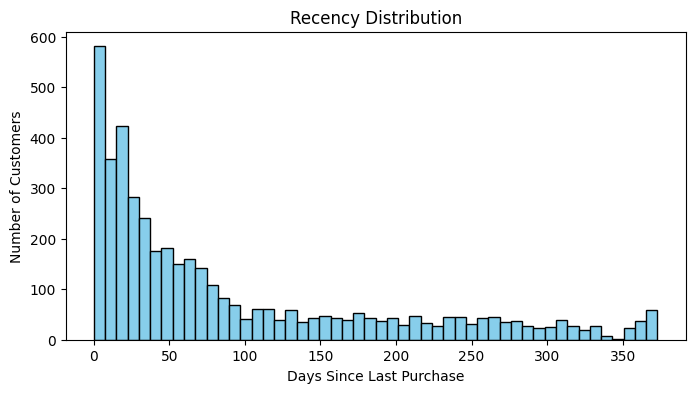

In [480]:
plt.figure(figsize=(8,4))
plt.hist(df_rfm['Recency'], bins=50, color='skyblue', edgecolor='black')
plt.title("Recency Distribution")
plt.xlabel("Days Since Last Purchase")
plt.ylabel("Number of Customers")
plt.show()

Frequency distribution:

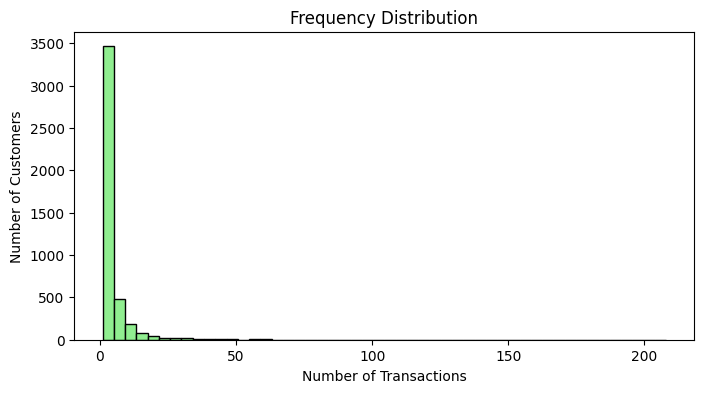

In [481]:
plt.figure(figsize=(8,4))
plt.hist(df_rfm['Frequency'], bins=50, color='lightgreen', edgecolor='black')
plt.title("Frequency Distribution")
plt.xlabel("Number of Transactions")
plt.ylabel("Number of Customers")
plt.show()

Monetary distribution:

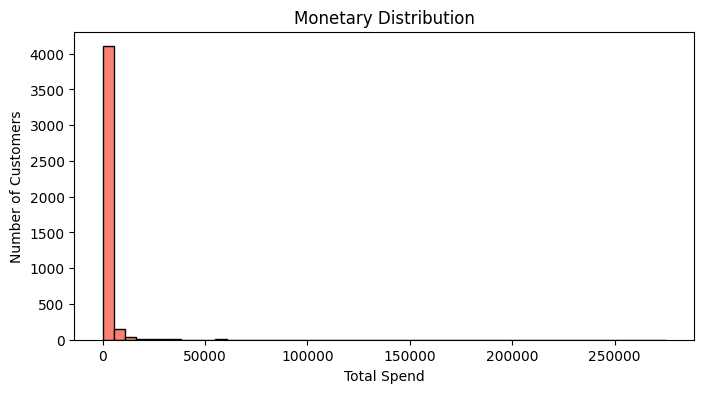

In [482]:
plt.figure(figsize=(8,4))
plt.hist(df_rfm['Monetary'], bins=50, color='salmon', edgecolor='black')
plt.title("Monetary Distribution")
plt.xlabel("Total Spend")
plt.ylabel("Number of Customers")
plt.show()

RFM scaling:

In [483]:
df_rfm_features = df_rfm[['Recency', 'Frequency', 'Monetary']]

scaler = StandardScaler()
df_rfm_scaled = scaler.fit_transform(df_rfm_features)

Elbow method:

In [484]:
clusters = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_rfm_scaled)
    clusters.append(kmeans.inertia_)

Elbow plot:

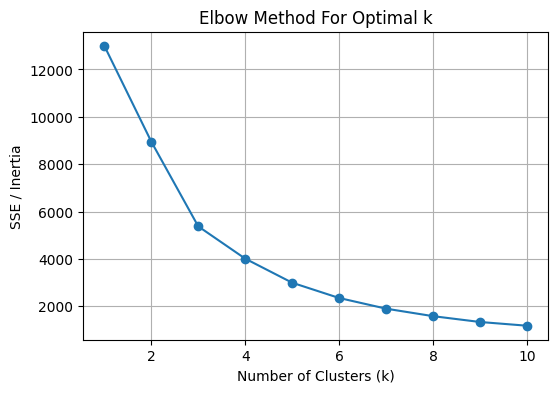

In [485]:
plt.figure(figsize=(6, 4))
plt.plot(k_range, clusters, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE / Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

KMeans Model:

In [486]:
kmeans_rfm = KMeans(n_clusters=4, random_state=42, n_init=10)
df_rfm['Cluster'] = kmeans_rfm.fit_predict(df_rfm_scaled)
df_rfm

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12347.0,1,7,4310.00,0
1,12348.0,74,4,1797.24,0
2,12349.0,18,1,1757.55,0
3,12350.0,309,1,334.40,1
4,12352.0,35,8,2506.04,0
...,...,...,...,...,...
4329,18280.0,277,1,180.60,1
4330,18281.0,180,1,80.82,1
4331,18282.0,7,2,178.05,0
4332,18283.0,3,16,2094.88,3


Cluster details:

In [487]:
cluster_summary = df_rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).round()

print(cluster_summary)

         Recency  Frequency  Monetary  Count
Cluster                                     
0           43.0        4.0    1358.0   3055
1          247.0        2.0     499.0   1070
2            7.0       89.0  121492.0     12
3           11.0       23.0   12037.0    197


Cluster plot:

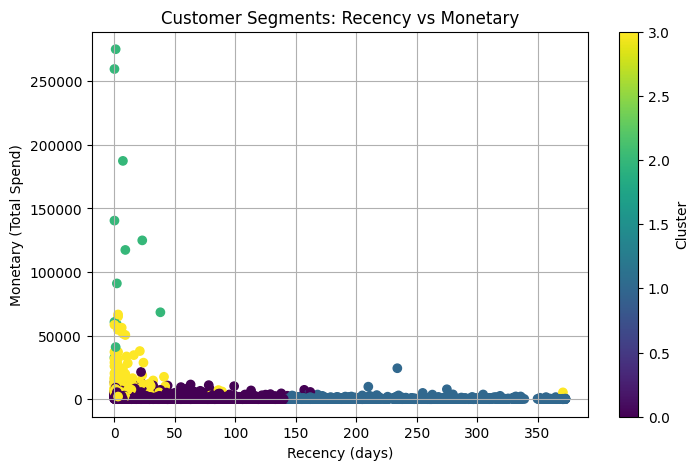

In [488]:
plt.figure(figsize=(8, 5))
plt.scatter(df_rfm['Recency'], df_rfm['Monetary'], c=df_rfm['Cluster'], cmap='viridis')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary (Total Spend)')
plt.title('Customer Segments: Recency vs Monetary')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

Cluster Labeling:

In [489]:
cluster_labels = {
    0: "Regular",
    1: "At-Risk",
    2: "High-Value",
    3: "Occasional"
}

In [490]:
df_rfm['Cluster'] = df_rfm['Cluster'].map(rfm_labels)

Dataset view:

In [491]:
df_rfm

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12347.0,1,7,4310.00,Occasional
1,12348.0,74,4,1797.24,Occasional
2,12349.0,18,1,1757.55,Occasional
3,12350.0,309,1,334.40,At-Risk
4,12352.0,35,8,2506.04,Occasional
...,...,...,...,...,...
4329,18280.0,277,1,180.60,At-Risk
4330,18281.0,180,1,80.82,At-Risk
4331,18282.0,7,2,178.05,Occasional
4332,18283.0,3,16,2094.88,High-Value


Dataset save:

In [492]:
df_rfm.to_csv('customer_rfm.csv')

Model save:

In [493]:
dit_model = {"model":kmeans_rfm,"scaler":scaler}

with open('rfm_model.pkl','wb') as f:
    pickle.dump(dit_model,f)

# **Product Recommendations**

Products:

In [494]:
products = df_clean[['Description']].drop_duplicates().dropna().reset_index(drop=True)
products

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
...,...
3871,"LETTER ""U"" BLING KEY RING"
3872,"LETTER ""W"" BLING KEY RING"
3873,"LETTER ""Z"" BLING KEY RING"
3874,PINK CRYSTAL SKULL PHONE CHARM


Products clean:

In [495]:
sorted(products['Description'])

[' 4 PURPLE FLOCK DINNER CANDLES',
 " 50'S CHRISTMAS GIFT BAG LARGE",
 ' DOLLY GIRL BEAKER',
 ' I LOVE LONDON MINI BACKPACK',
 ' I LOVE LONDON MINI RUCKSACK',
 ' NINE DRAWER OFFICE TIDY',
 ' OVAL WALL MIRROR DIAMANTE ',
 ' RED SPOT GIFT BAG LARGE',
 ' SET 2 TEA TOWELS I LOVE LONDON ',
 ' SPACEBOY BABY GIFT SET',
 ' TOADSTOOL BEDSIDE LIGHT ',
 ' TRELLIS COAT RACK',
 '10 COLOUR SPACEBOY PEN',
 '12 COLOURED PARTY BALLOONS',
 '12 DAISY PEGS IN WOOD BOX',
 '12 EGG HOUSE PAINTED WOOD',
 '12 HANGING EGGS HAND PAINTED',
 '12 IVORY ROSE PEG PLACE SETTINGS',
 '12 MESSAGE CARDS WITH ENVELOPES',
 '12 PENCIL SMALL TUBE WOODLAND',
 '12 PENCILS SMALL TUBE RED RETROSPOT',
 '12 PENCILS SMALL TUBE SKULL',
 '12 PENCILS TALL TUBE POSY',
 '12 PENCILS TALL TUBE RED RETROSPOT',
 '12 PENCILS TALL TUBE SKULLS',
 '12 PENCILS TALL TUBE WOODLAND',
 '12 PINK HEN+CHICKS IN BASKET',
 '12 PINK ROSE PEG PLACE SETTINGS',
 '12 RED ROSE PEG PLACE SETTINGS',
 '15 PINK FLUFFY CHICKS IN BOX',
 '15CM CHRISTMAS GLASS BALL 20 

In [496]:
def remove_nums(desc):
    return ' '.join([i for i in desc.split() if not i.isdigit()])

products['Description'] = products['Description'].apply(remove_nums)

In [497]:
sorted(products['Description'])

['15CM CHRISTMAS GLASS BALL LIGHTS',
 '18PC WOODEN CUTLERY SET DISPOSABLE',
 '3D CHRISTMAS STAMPS STICKERS',
 '3D DOG PICTURE PLAYING CARDS',
 '3D HEARTS HONEYCOMB PAPER GARLAND',
 '3D SHEET OF CAT STICKERS',
 '3D SHEET OF DOG STICKERS',
 '3D TRADITIONAL CHRISTMAS STICKERS',
 '3D VINTAGE CHRISTMAS STICKERS',
 "50'S CHRISTMAS GIFT BAG LARGE",
 "50'S CHRISTMAS PAPER GIFT BAG",
 '50CM METAL STRING WITH CLIPS',
 '6PC WOOD PLATE SET DISPOSABLE',
 "70'S ALPHABET WALL ART",
 'A PRETTY THANK YOU CARD',
 'A4 WALL TIDY BLUE OFFICE',
 'A4 WALL TIDY RED FLOWERS',
 'ABC TREASURE BOOK BOX',
 'ABSTRACT CIRCLE JOURNAL',
 'ABSTRACT CIRCLES POCKET BOOK',
 'ABSTRACT CIRCLES SKETCHBOOK',
 'ACRYLIC GEOMETRIC LAMP',
 'ACRYLIC HANGING JEWEL,BLUE',
 'ACRYLIC HANGING JEWEL,PINK',
 'ACRYLIC JEWEL ANGEL,PINK',
 'ACRYLIC JEWEL ICICLE, BLUE',
 'ACRYLIC JEWEL ICICLE, PINK',
 'ACRYLIC JEWEL SNOWFLAKE, PINK',
 'ACRYLIC JEWEL SNOWFLAKE,PINK',
 'ADULT APRON APPLE DELIGHT',
 'ADVENT CALENDAR GINGHAM SACK',
 'AFGHAN SLIP

TF-IDF vectorization:

In [498]:
tfidf = TfidfVectorizer(stop_words='english')
products_vectorized = tfidf.fit_transform(products['Description'])

Cosine similarity:

In [499]:
products_similar = cosine_similarity(products_vectorized)

Product index:

In [500]:
product_index = pd.Series(products.index, index=products['Description'])
product_index

Description
WHITE HANGING HEART T-LIGHT HOLDER        0
WHITE METAL LANTERN                       1
CREAM CUPID HEARTS COAT HANGER            2
KNITTED UNION FLAG HOT WATER BOTTLE       3
RED WOOLLY HOTTIE WHITE HEART.            4
                                       ... 
LETTER "U" BLING KEY RING              3871
LETTER "W" BLING KEY RING              3872
LETTER "Z" BLING KEY RING              3873
PINK CRYSTAL SKULL PHONE CHARM         3874
CREAM HANGING HEART T-LIGHT HOLDER     3875
Length: 3876, dtype: int64

Recommendation function:

In [501]:
def product_recommender(desc, n=5):
    if desc not in product_index:
        return f"'{desc}' not found."

    id = product_index[desc]
    similarity_scores = list(enumerate(products_similar[id]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    recommendations = [i[0] for i in similarity_scores[1:n+1]]
    return products.iloc[recommendations].reset_index(drop=True)

Product search:

In [502]:
product_recommender("RED RETROSPOT MUG")

,Description
0,SMALL RED RETROSPOT MUG IN BOX
1,VINTAGE RED MUG
2,RED RETROSPOT WRAP
3,RED RETROSPOT BOWL
4,SMALL WHITE RETROSPOT MUG IN BOX


Save products:

In [503]:
dit_products = {"products":products,"product_vector":products_vectorized,"index":product_index}

with open('product_recommends.pkl','wb') as f:
    pickle.dump(dit_products,f)